In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
import imageio.v3 as iio
import time
import os

# Suppress the DecompressionBombWarning
import warnings
from PIL import Image
warnings.simplefilter('ignore', Image.DecompressionBombWarning)

## Load Files

In [2]:
# read labels files
train_labels_df = pd.read_csv("train_labels.csv")
test_labels_df = pd.read_csv("test_labels.csv")

In [3]:
def read_data(folder_name, labels_df):
    data = []
    labels = []
    i = 0
    files = os.listdir(folder_name)
    for filename in files:
        i += 1
        data.append(iio.imread(os.path.join(folder_name, filename)).flatten())
        labels.append(labels_df.loc[labels_df["Id"] == os.path.splitext(filename)[0], "Class"].iloc[0])
        print(f"|{'='*int(i*50/len(files)) + '-'*(50-int(i*50/len(files)))}| {i*100//len(files)}%", end="\r")
    print()
    return data, labels

In [4]:
# read images file

start = time.time()

# read asm train images
print("Reading asm train files...")
asm_data_train, asm_labels_train = read_data("train_asm_image", train_labels_df)

# read asm test images
print("Reading bytes train files...")
asm_data_test, asm_labels_test = read_data("test_asm_image", test_labels_df)

# read bytes train images
print("Reading asm test files...")
bytes_data_train, bytes_labels_train = read_data("train_byte_image", train_labels_df)

# read bytes test images
print("Reading bytes test files...")
bytes_data_test, bytes_labels_test = read_data("test_byte_image", test_labels_df)

print("\nCompleted!")
end = time.time()

print("\nTime taken: {}m {}s".format(int((end-start)//60), int((end-start)%60)))

Reading asm train files...
|==================================================| 100%
Reading bytes train files...
|==================================================| 100%
Reading asm test files...
|==================================================| 100%
Reading bytes test files...
|==================================================| 100%

Completed!

Time taken: 2m 21s


## Preprocess Step

In [14]:
# pre process images to a standard size
image_size = (64, 64)

def standardise_size(arr, size):
    if arr.size < size[0]*size[1]:
        return np.pad(arr, (0, size[0]*size[1]-arr.size), mode='constant', constant_values=0).reshape(size[0], size[1])
    else:
        return arr[:(size[0]*size[1])].reshape(size[0], size[1])

asm_data_train_standardised = np.array([standardise_size(arr, image_size) for arr in asm_data_train])
asm_data_test_standardised = np.array([standardise_size(arr, image_size) for arr in asm_data_test])

In [15]:
image_size_bytes = (512, 512)

bytes_data_train_standardised = np.array([standardise_size(arr, image_size_bytes) for arr in bytes_data_train])
bytes_data_test_standardised = np.array([standardise_size(arr, image_size_bytes) for arr in bytes_data_test])

In [16]:
# pre process labels into one hot encodings
def one_hot_encode(labels):
    labels = np.array(labels)
    labels[labels < 5] = labels[labels < 5] - 1
    labels[labels > 5] = labels[labels > 5] - 2
    encoded_labels = np.identity(8)[labels]
    return encoded_labels

asm_labels_train_encoded = one_hot_encode(asm_labels_train)
asm_labels_test_encoded = one_hot_encode(asm_labels_test)
bytes_labels_train_encoded = one_hot_encode(bytes_labels_train)
bytes_labels_test_encoded = one_hot_encode(bytes_labels_test)

## Models

### ASM CNN Model

In [19]:
# create model
asm_cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation=tf.keras.activations.leaky_relu, padding='same', kernel_regularizer=tf.keras.regularizers.L2(1e-3), input_shape=(image_size[0], image_size[1], 1)),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    tf.keras.layers.Conv2D(64, (3,3), activation=tf.keras.activations.leaky_relu, padding='same', kernel_regularizer=tf.keras.regularizers.L2(1e-3)),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    tf.keras.layers.Conv2D(64, (3,3), activation=tf.keras.activations.leaky_relu, padding='same', kernel_regularizer=tf.keras.regularizers.L2(1e-3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.L2(1e-3)),
    tf.keras.layers.Dense(8, activation="softmax")
])

# define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# compile model
asm_cnn_model.compile(optimizer="adam", loss=tf.keras.losses.categorical_crossentropy, metrics=["accuracy"])

C:\Users\Vincent\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
# train model
asm_cnn_history = asm_cnn_model.fit(asm_data_train_standardised, asm_labels_train_encoded, validation_data=(asm_data_test_standardised, asm_labels_test_encoded), epochs = 50, callbacks=[early_stopping])

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.7748 - loss: 2.8582 - val_accuracy: 0.8844 - val_loss: 1.4059
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.9276 - loss: 0.7710 - val_accuracy: 0.8625 - val_loss: 1.1108
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9459 - loss: 0.6072 - val_accuracy: 0.9094 - val_loss: 0.8160
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9705 - loss: 0.4980 - val_accuracy: 0.8813 - val_loss: 1.0346
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.9688 - loss: 0.5334 - val_accuracy: 0.9281 - val_loss: 0.6730
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.9800 - loss: 0.4693 - val_accuracy: 0.8813 - val_loss: 1.0965
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.9892 - loss: 0.4572 - val_accuracy: 0.9062 - val_loss: 0.8007
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.9946 - loss: 0.4212 - val_accuracy: 0.9250 - v

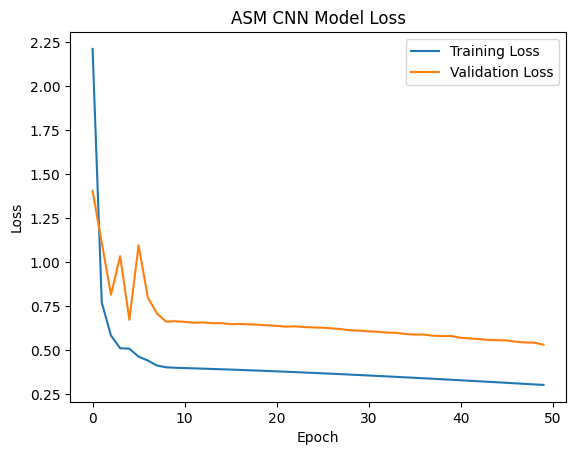

In [22]:
# plot training & validation loss values
plt.plot(asm_cnn_history.history['loss'], label='Training Loss')
plt.plot(asm_cnn_history.history['val_loss'], label='Validation Loss')
plt.title('ASM CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [23]:
y_pred = np.argmax(asm_cnn_model.predict(asm_data_test_standardised, verbose=False), axis=1) + 1
y_true = np.argmax(asm_labels_test_encoded, axis=1) + 1

In [24]:
# classification report
print(classification_report(y_true, y_pred, zero_division=0))

              precision    recall  f1-score   support

           1       0.93      0.95      0.94        40
           2       1.00      1.00      1.00        40
           3       0.86      0.90      0.88        40
           4       0.98      1.00      0.99        40
           5       0.97      0.93      0.95        40
           6       0.92      0.88      0.90        40
           7       0.93      0.93      0.93        40
           8       0.93      0.93      0.93        40

    accuracy                           0.94       320
   macro avg       0.94      0.94      0.94       320
weighted avg       0.94      0.94      0.94       320



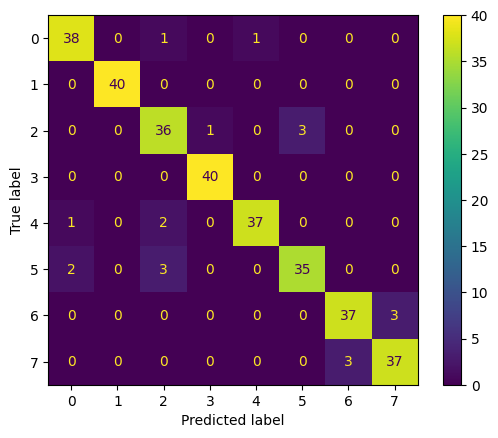

In [25]:
# confusion matrix
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm).plot()

In [33]:
# save the model
asm_cnn_model.save('asm_cnn_model.h5')

In [8]:
# load the model
asm_cnn_model = tf.keras.models.load_model('asm_cnn_model.h5')

### Bytes CNN Model

In [26]:
# create model
bytes_cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation=tf.keras.activations.leaky_relu, padding='same', kernel_regularizer=tf.keras.regularizers.L2(1e-3), input_shape=(image_size_bytes[0], image_size_bytes[1], 1)),
    tf.keras.layers.MaxPooling2D((4, 4), padding='same'),
    tf.keras.layers.Conv2D(64, (3,3), activation=tf.keras.activations.leaky_relu, padding='same', kernel_regularizer=tf.keras.regularizers.L2(1e-3)),
    tf.keras.layers.MaxPooling2D((4, 4), padding='same'),
    tf.keras.layers.Conv2D(64, (3,3), activation=tf.keras.activations.leaky_relu, padding='same', kernel_regularizer=tf.keras.regularizers.L2(1e-3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.L2(1e-3)),
    tf.keras.layers.Dense(8, activation="softmax")
])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# compile model
bytes_cnn_model.compile(optimizer="adam", loss=tf.keras.losses.categorical_crossentropy, metrics=["accuracy"])

C:\Users\Vincent\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
# train model
bytes_cnn_history = bytes_cnn_model.fit(bytes_data_train_standardised, bytes_labels_train_encoded, validation_data=(bytes_data_test_standardised, bytes_labels_test_encoded), epochs=50,  callbacks=[early_stopping])

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.3187 - loss: 765.4734 - val_accuracy: 0.5969 - val_loss: 59.0012
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.6196 - loss: 48.0457 - val_accuracy: 0.7969 - val_loss: 11.0715
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.8031 - loss: 10.8297 - val_accuracy: 0.7937 - val_loss: 11.3018
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.8357 - loss: 7.4774 - val_accuracy: 0.7937 - val_loss: 13.6496
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.8604 - loss: 6.3903 - val_accuracy: 0.8719 - val_loss: 5.9347
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.9655 - loss: 1.0807 - val_accuracy: 0.8469 - val_loss: 5.6070
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.9743 - loss: 0.7050 - val_accuracy: 0.8313 - val_loss: 5.6940
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.9499 - loss: 1.2972 - val_accuracy: 0.8562 - v

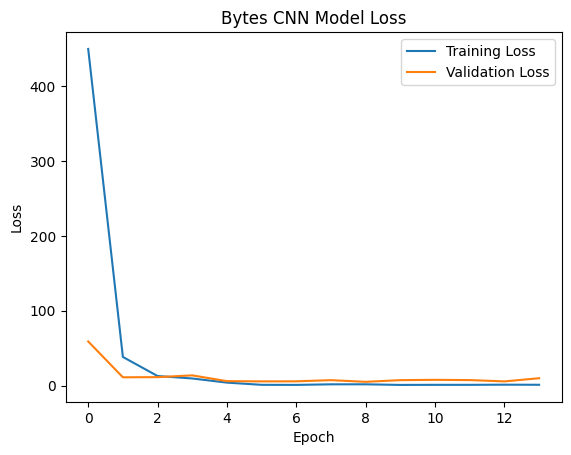

In [29]:
# plot training & validation loss values
plt.plot(bytes_cnn_history.history['loss'], label='Training Loss')
plt.plot(bytes_cnn_history.history['val_loss'], label='Validation Loss')
plt.title('Bytes CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [30]:
y_pred = np.argmax(bytes_cnn_model.predict(bytes_data_test_standardised, verbose=False), axis=1) + 1
y_true = np.argmax(bytes_labels_test_encoded, axis=1) + 1

In [31]:
# classification report
print(classification_report(y_true, y_pred, zero_division=0))

              precision    recall  f1-score   support

           1       0.67      0.80      0.73        40
           2       0.95      0.90      0.92        40
           3       0.93      0.95      0.94        40
           4       0.90      0.93      0.91        40
           5       0.87      0.65      0.74        40
           6       0.95      1.00      0.98        40
           7       0.89      0.80      0.84        40
           8       0.89      0.97      0.93        40

    accuracy                           0.88       320
   macro avg       0.88      0.88      0.87       320
weighted avg       0.88      0.88      0.87       320



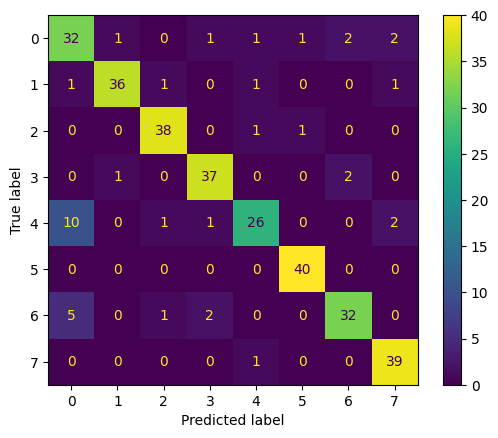

In [32]:
# confusion matrix
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm).plot()

In [34]:
# save the model
bytes_cnn_model.save('bytes_cnn_model.h5')

In [6]:
# load the model
bytes_cnn_model = tf.keras.models.load_model('bytes_cnn_model.h5')

## Model Analysis

### Model Summary

In [9]:
print("ASM CNN Model Summary")
asm_cnn_model.summary()

ASM CNN Model Summary


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       2,097,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,154,058 (8.22 MB)

 Trainable params: 2,154,056 (8.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [10]:
print("Bytes CNN Model Summary")
bytes_cnn_model.summary()

Bytes CNN Model Summary


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 512, 512, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       8,388,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,445,514 (32.22 MB)

 Trainable params: 8,445,512 (32.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

## Embedding Analysis

In [11]:
# pre process labels into one hot encodings
def correct_class(labels):
    labels = np.array(labels)
    labels[labels < 5] = labels[labels < 5] - 1
    labels[labels > 5] = labels[labels > 5] - 2
    return labels

asm_labels_train_corrected = correct_class(asm_labels_train)
asm_labels_test_corrected = correct_class(asm_labels_test)
bytes_labels_train_corrected = correct_class(bytes_labels_train)
bytes_labels_test_corrected = correct_class(bytes_labels_test)

In [12]:
def plot_tsne(saved_model, x_test, y_test, title="Embedding Model"):
    # Load the saved model
    model = tf.keras.models.load_model(saved_model)

    # Define a new model that outputs from the second-to-last layer
    second_last_layer = model.layers[-2].output  # Access the second-to-last layer
    embedding_model = tf.keras.Model(inputs=model.inputs, outputs=second_last_layer)

    # Extract embeddings
    embeddings = embedding_model.predict(x_test)

    # Apply t-SNE for 2D visualization
    tsne = TSNE(n_components=2, init="pca")
    embeddings_2d = tsne.fit_transform(embeddings)

    # Plot the t-SNE results
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_test, cmap='viridis', s=10)
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()

### ASM CNN TSNE

 1/10 ━━━━━━━━━━━━━━━━━━━━ 2s 326ms/step

C:\Users\Vincent\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer_1']. Received: the structure of inputs=*
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


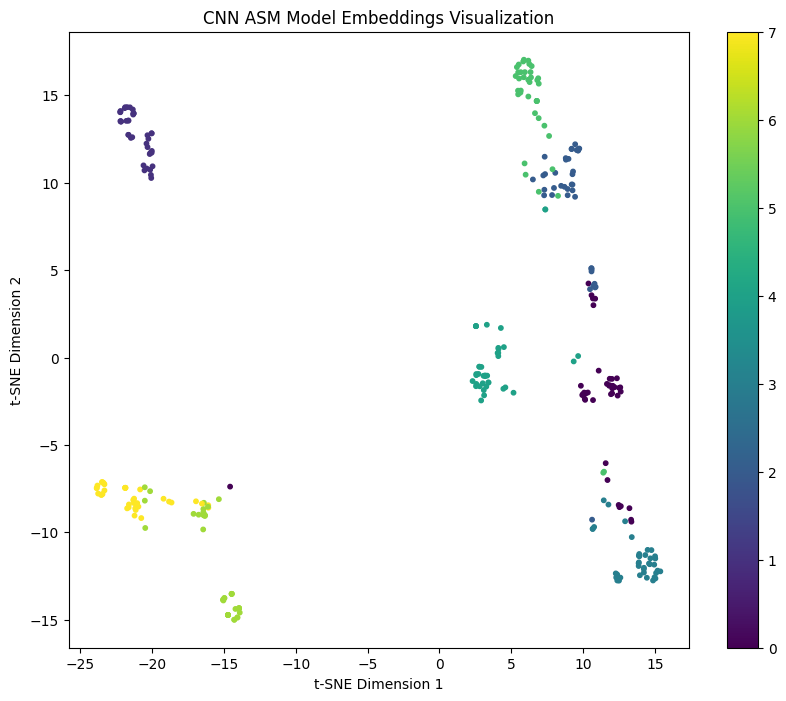

In [16]:
plot_tsne('asm_cnn_model.h5', asm_data_test_standardised, asm_labels_test_corrected, title="CNN ASM Model Embeddings Visualization")

### Bytes CNN TSNE

C:\Users\Vincent\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer_2']. Received: the structure of inputs=*
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 279ms/step


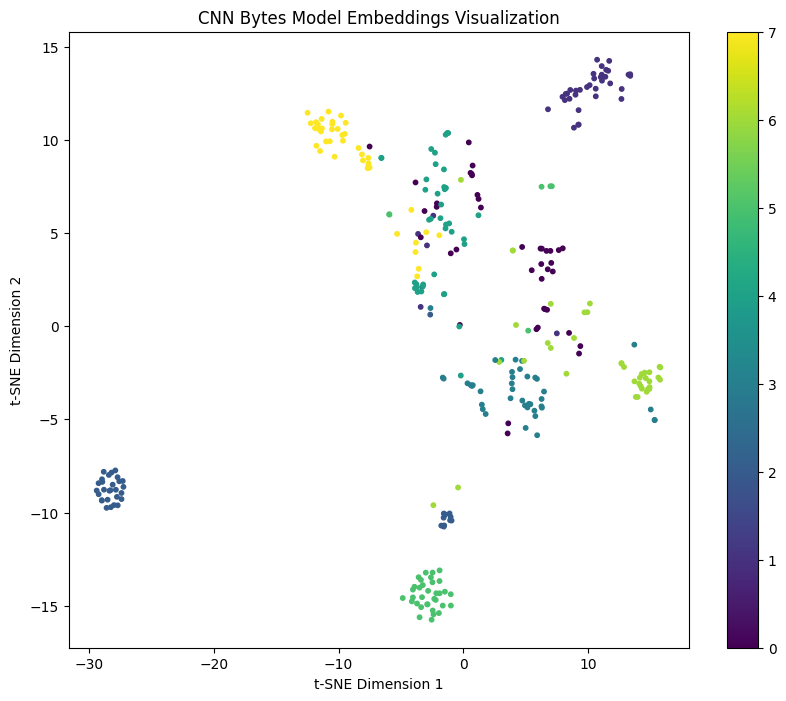

In [17]:
plot_tsne('bytes_cnn_model.h5', bytes_data_test_standardised, bytes_labels_test_corrected, title="CNN Bytes Model Embeddings Visualization")